# Gammapy imports

In [1]:
from gammapy.estimators import SensitivityEstimator
from gammapy.data import FixedPointingInfo, Observation, observatory_locations
from gammapy.datasets import SpectrumDataset, SpectrumDatasetOnOff
from gammapy.makers import SpectrumDatasetMaker
from gammapy.maps import MapAxis, RegionGeom
from gammapy.irf import load_irf_dict_from_file, RadMax2D
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion, PointSkyRegion
from pathlib import Path


# Further imports

In [2]:
import uproot

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from astropy.visualization import quantity_support
quantity_support();

# Sensitivity function

In [8]:
def gp_sensitivity_curve(irfs, root_e_bins, enclosure=True, conf={}):

    energy_axis = MapAxis.from_nodes(root_e_bins,
                                     interp="log",
                                     name="energy").to_node_type("edges")
    energy_axis_true = MapAxis.from_energy_bounds(
        conf.get("E_true_min",
                 0.01 * u.TeV),
        conf.get("E_true_max",
                 350 * u.TeV),
        nbin=conf.get("E_true_nbin", 150),
        name="energy_true"
    )
    pointing = SkyCoord(ra=conf.get("point_ra", 0 * u.deg), dec=conf.get("point_dec", 0 * u.deg))
    on_region_radius = conf.get("on_region", 0.1 * u.deg)
    offset = conf.get("point_offset", 0.5 * u.deg)
    offset_dir = conf.get("point_offset_dir", 0.0 * u.deg)

    pointing_info = FixedPointingInfo(fixed_icrs=pointing)
    source_position = pointing.directional_offset_by(offset_dir, offset)
    if enclosure:
        on_region = CircleSkyRegion(source_position, radius=on_region_radius)
    else:
        on_region = PointSkyRegion(source_position)

    geom = RegionGeom.create(on_region, axes=[energy_axis])
    empty_dataset = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

    location = observatory_locations["cta_south"]
    livetime = conf.get("livetime", 50.0 * u.h)

    obs = Observation.create(
        pointing=pointing_info, irfs=irfs, livetime=livetime, location=location
    )
    spectrum_maker = SpectrumDatasetMaker(
        selection=["exposure", "edisp", "background"],
        containment_correction=False,
    )
    dataset = spectrum_maker.run(empty_dataset, obs)
    if enclosure:
        containment = 0.68
        dataset.exposure *= containment
        on_radii = obs.psf.containment_radius(
            energy_true=energy_axis.center, offset=offset, fraction=containment
        )
        factor = (1 - np.cos(on_radii)) / (1 - np.cos(on_region_radius))
        dataset.background *= factor.value.reshape((-1, 1, 1))

    dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
        dataset=dataset, acceptance=1, acceptance_off=5
    )
    sensitivity_estimator = SensitivityEstimator(
        gamma_min=10,
        n_sigma=5,
        bkg_syst_fraction=0.05,
    )
    gp_sensitivity_table = sensitivity_estimator.run(dataset_on_off)
    return gp_sensitivity_table["e_ref"], gp_sensitivity_table["e2dnde"], gp_sensitivity_table

# Load irfs

In [9]:
def load_sensitivity(root_file):
    irf_root = uproot.open(root_file)
    sens, sens_ebins = irf_root["DiffSens"].to_numpy()
    sens_ebins = 10**sens_ebins * u.TeV
    sens = sens * u.erg / u.s / u.cm**2
    return sens, sens_ebins


def load_irf_with_rad_max(irf_file, root_file):
    irf_root = uproot.open(root_file)
    theta, log_E = irf_root['ThetaCut;1'].to_numpy()
    Eaxes = MapAxis(10**log_E, name="energy", unit="TeV")
    offset = MapAxis([0, 5], name="offset", unit="degree")

    irf_table = load_irf_dict_from_file(irf_file)
    irf_table["rad_max"] = RadMax2D(
        data=theta[..., np.newaxis],
        axes=[Eaxes, offset],
        unit="deg",
        interp_kwargs={"method": "nearest", "fill_value": None})
    return irf_table

In [10]:
IRF_ROOT = Path("./IRFs/")

prod3_irf_fits = IRF_ROOT / "Prod3_South_z20_S_50h_irf_file.fits"
prod3_irf_root = IRF_ROOT / "CTA-Performance-prod3b-v2-South-20deg-S-50h.root"


prod5_irf_fits = IRF_ROOT / 'Prod5-South-20deg-SouthAz-14MSTs37SSTs.180000s-v0.1.fits.gz'
prod5_irf_root = IRF_ROOT / 'Prod5-South-20deg-SouthAz-14MSTs37SSTs.180000s-v0.1.root'

In [11]:
prod5_sens, p5_en = load_sensitivity(prod5_irf_root)
irf_tab_p5 = load_irf_with_rad_max(prod5_irf_fits, prod5_irf_root)
prod3_sens, p3_en = load_sensitivity(prod3_irf_root)
irf_tab_p3 = load_irf_with_rad_max(prod3_irf_fits, prod3_irf_root)


# Calculate and plot sensitivities

/local/home/tb273079/miniconda3/envs/gp-sensitivity/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


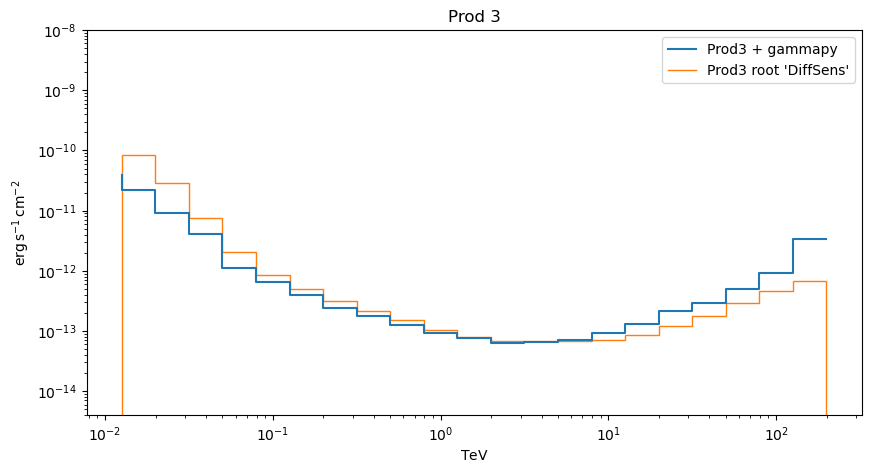

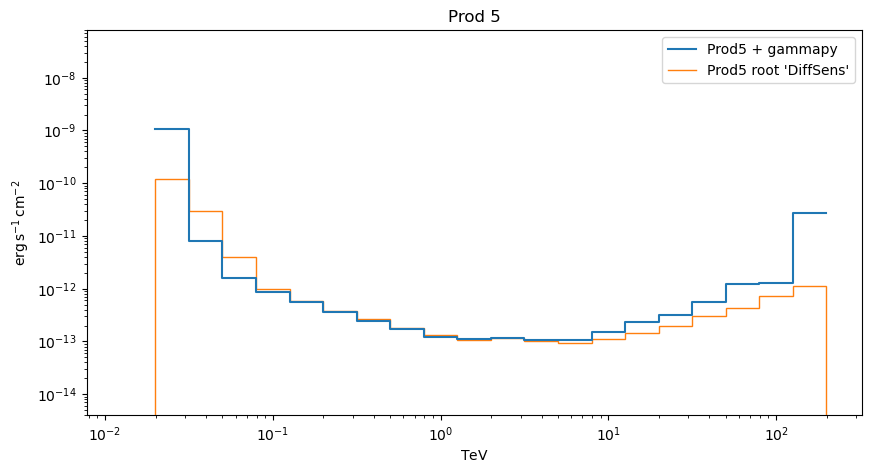

In [12]:
p3_gE, p3_gSens, _ = gp_sensitivity_curve(irf_tab_p3, p3_en, enclosure=True, conf={"on_region": 0.3 * u.deg})
p5_gE, p5_gSens, _ = gp_sensitivity_curve(irf_tab_p5, p5_en, enclosure=True, conf={"on_region": 0.3 * u.deg})

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.step(p3_gE, p3_gSens, label="Prod3 + gammapy")
plt.stairs(prod3_sens, p3_en, label="Prod3 root 'DiffSens'")
plt.title("Prod 3")

plt.ylim(4e-15, 1e-8)
plt.loglog()
plt.legend()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.step(p5_gE, p5_gSens, label="Prod5 + gammapy")
plt.stairs(prod5_sens, p5_en, label="Prod5 root 'DiffSens'")
plt.title("Prod 5")

plt.ylim(4e-15, 8e-8)
plt.loglog()
plt.legend()

<Axes: xlabel='True Energy [$\\mathrm{TeV}$]', ylabel='Energy / True Energy [$\\mathrm{}$]'>

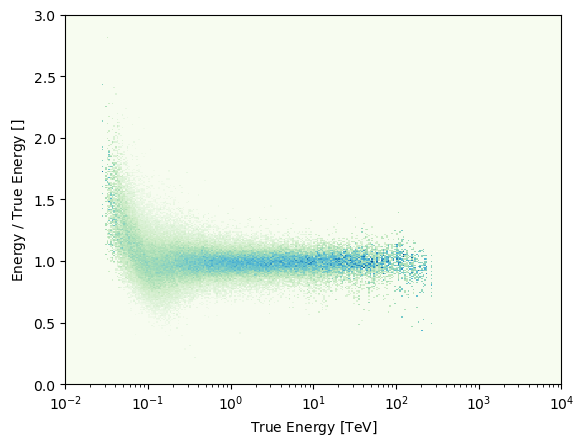

In [55]:
edisp = irf_tab_p5["edisp"]
edisp.plot_bias()